In [1]:
import tensorflow as tf
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Program\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\pyth

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
tf.set_random_seed(1)
np.random.seed(1)

Extracting ./mnist\train-images-idx3-ubyte.gz
Extracting ./mnist\train-labels-idx1-ubyte.gz
Extracting ./mnist\t10k-images-idx3-ubyte.gz
Extracting ./mnist\t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)


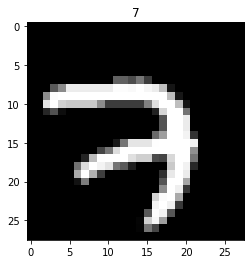

In [3]:
# Hyper Parameters
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate

# data
mnist = input_data.read_data_sets('./mnist', one_hot=True)              # they has been normalized to range (0,1)
test_x = mnist.test.images[:2000]
test_y = mnist.test.labels[:2000]

# plot one example
print(mnist.train.images.shape)     # (55000, 28 * 28)
print(mnist.train.labels.shape)   # (55000, 10)
plt.imshow(mnist.train.images[0].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(mnist.train.labels[0]))
plt.show()

In [4]:
# tensorflow placeholders
tf_x = tf.placeholder(tf.float32, [None, TIME_STEP * INPUT_SIZE])       # shape(batch, 784)
image = tf.reshape(tf_x, [-1, TIME_STEP, INPUT_SIZE])                   # (batch, height, width, channel)
tf_y = tf.placeholder(tf.int32, [None, 10])                             # input y

In [5]:
n_classes = 10  # MNIST classes (0-9 digits)

# RNN
with tf.variable_scope('LSTMCell'):
    rnn_cell = tf.nn.rnn_cell.LSTMCell(num_units=64)

with tf.variable_scope('dynamic_rnn'):
    outputs, (h_c, h_n) = tf.nn.dynamic_rnn(
        rnn_cell,                   # cell you have chosen
        image,                      # input
        initial_state=None,         # the initial hidden state
        dtype=tf.float32,           # must given if set initial_state = None
        time_major=False,           # False: (batch, time step, input); True: (time step, batch, input)
    )
    
    output = tf.layers.dense(outputs[:, -1, :], n_classes)              # output based on the last output step

with tf.name_scope('loss'):
    loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)           # compute cost
    tf.summary.scalar('loss', loss)     # add loss to scalar summary
    
    
with tf.name_scope('train'):
    train_op = tf.train.AdamOptimizer(LR).minimize(loss)

with tf.name_scope('accuracy'):
    accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
        labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1),)[1]



In [6]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)  
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) 

In [7]:
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) # the local var is for accuracy_op
writer = tf.summary.FileWriter('rnn/classification', sess.graph)     # write to file
merge_op = tf.summary.merge_all()                       # operation to merge all summary
sess.run(init_op)     # initialize var in graph

In [8]:
saver = tf.train.Saver()  # define a saver for saving and restoring
save_path = 'rnn/classification/model.ckpt'
for step in range(1200):    # training
    b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
    _, loss_ = sess.run([train_op, loss], {tf_x: b_x, tf_y: b_y})
    result = sess.run(merge_op, {tf_x: b_x, tf_y: b_y}) 
    writer.add_summary(result, step)
    if step % 50 == 0:      # testing
        saver.save(sess, save_path, global_step=step)
        accuracy_ = sess.run(accuracy, {tf_x: test_x, tf_y: test_y})
        print('train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

train loss: 2.3040 | test accuracy: 0.13
train loss: 0.8905 | test accuracy: 0.41
train loss: 0.6183 | test accuracy: 0.52
train loss: 0.5238 | test accuracy: 0.60
train loss: 0.4562 | test accuracy: 0.65
train loss: 0.1845 | test accuracy: 0.69
train loss: 0.3138 | test accuracy: 0.72
train loss: 0.1180 | test accuracy: 0.75
train loss: 0.1563 | test accuracy: 0.77
train loss: 0.3933 | test accuracy: 0.78
train loss: 0.0675 | test accuracy: 0.80
train loss: 0.2283 | test accuracy: 0.81
train loss: 0.1033 | test accuracy: 0.82
train loss: 0.1577 | test accuracy: 0.83
train loss: 0.1588 | test accuracy: 0.84
train loss: 0.1831 | test accuracy: 0.84
train loss: 0.0889 | test accuracy: 0.85
train loss: 0.2454 | test accuracy: 0.85
train loss: 0.1992 | test accuracy: 0.86
train loss: 0.0612 | test accuracy: 0.86
train loss: 0.0981 | test accuracy: 0.87
train loss: 0.1696 | test accuracy: 0.87
train loss: 0.1592 | test accuracy: 0.88
train loss: 0.1858 | test accuracy: 0.88


# Saver 保存讀取

In [9]:
def save():  
    saver = tf.train.Saver()  # define a saver for saving and restoring
    saver.save(sess, save_path)  # meta_graph is not recommended       

save()

In [10]:
# destroy previous net
tf.reset_default_graph()

def reload():
    print('This is reload')
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(save_path))       
        if ckpt and ckpt.model_checkpoint_path:
#             print(tf.train.latest_checkpoint('cnn'))            
            print('Found checkpoint, try to restore...')
            saver = tf.train.import_meta_graph(''.join([ckpt.model_checkpoint_path, '.meta']))   
            saver.restore(sess, tf.train.latest_checkpoint(save_path.replace('model.ckpt','')))

            # 列印出網路中可訓練的權重引數名
            for var in tf.trainable_variables():
                print(var)           
reload() 

This is reload
Found checkpoint, try to restore...
INFO:tensorflow:Restoring parameters from rnn/classification/model.ckpt
<tf.Variable 'dynamic_rnn/rnn/lstm_cell/kernel:0' shape=(92, 256) dtype=float32_ref>
<tf.Variable 'dynamic_rnn/rnn/lstm_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'dynamic_rnn/dense/kernel:0' shape=(64, 10) dtype=float32_ref>
<tf.Variable 'dynamic_rnn/dense/bias:0' shape=(10,) dtype=float32_ref>


# Reload 後繼續train

In [11]:
for step in range(1200):    # training
    b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
    _, loss_ = sess.run([train_op, loss], {tf_x: b_x, tf_y: b_y})
    result = sess.run(merge_op, {tf_x: b_x, tf_y: b_y}) 
    writer.add_summary(result, step)
    if step % 50 == 0:      # testing
        accuracy_ = sess.run(accuracy, {tf_x: test_x, tf_y: test_y})
        print('train loss: %.4f' % loss_, '| test accuracy: %.2f' % accuracy_)

train loss: 0.0695 | test accuracy: 0.88
train loss: 0.1408 | test accuracy: 0.89
train loss: 0.1159 | test accuracy: 0.89
train loss: 0.2122 | test accuracy: 0.89
train loss: 0.1707 | test accuracy: 0.89
train loss: 0.0908 | test accuracy: 0.89
train loss: 0.1014 | test accuracy: 0.90
train loss: 0.1640 | test accuracy: 0.90
train loss: 0.2737 | test accuracy: 0.90
train loss: 0.0221 | test accuracy: 0.90
train loss: 0.1412 | test accuracy: 0.90
train loss: 0.0480 | test accuracy: 0.91
train loss: 0.0511 | test accuracy: 0.91
train loss: 0.0925 | test accuracy: 0.91
train loss: 0.1257 | test accuracy: 0.91
train loss: 0.0494 | test accuracy: 0.91
train loss: 0.0087 | test accuracy: 0.91
train loss: 0.0560 | test accuracy: 0.91
train loss: 0.1176 | test accuracy: 0.92
train loss: 0.0213 | test accuracy: 0.92
train loss: 0.0151 | test accuracy: 0.92
train loss: 0.1508 | test accuracy: 0.92
train loss: 0.2267 | test accuracy: 0.92
train loss: 0.0102 | test accuracy: 0.92
